In [2]:
using AlgebraicPetri, DataFrames, DifferentialEquations, ModelingToolkit, Symbolics, EasyModelAnalysis, Catlab, Catlab.CategoricalAlgebra, JSON3, UnPack
using CSV, DataFrames
using ForwardDiff, Downloads

ArgumentError: ArgumentError: Package ForwardDiff not found in current path.
- Run `import Pkg; Pkg.add("ForwardDiff")` to install the ForwardDiff package.

1. Upload a ground-truth dataset and its documentation via a URL
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Hospitalizations.csv
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md 

In [1]:
using Downloads, URIs
using CSV
using DataFrames

urls = ["https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Cases.csv",
        "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Deaths.csv",
        "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Hospitalizations.csv"]

filenames = [URIs.unescapeuri(split(url, "/")[end]) for url in urls]
for (url, filename) in zip(urls, filenames)
    if !isfile(filename)
        Downloads.download(url, filename)
    end
end

# Read the local CSV files into DataFrames
dfc = CSV.read(filenames[1], DataFrame)
dfd = CSV.read(filenames[2], DataFrame)
dfh = CSV.read(filenames[3], DataFrame)

Row,date,location,location_name,value
,Date,String3,String31,Int64
1,2021-03-02,41,Oregon,19
2,2021-02-24,44,Rhode Island,19
3,2021-02-18,44,Rhode Island,12
4,2021-01-29,23,Maine,15
5,2021-01-29,30,Montana,26
6,2021-01-28,23,Maine,20
7,2021-01-28,46,South Dakota,13
8,2021-01-22,16,Idaho,23
9,2021-01-22,46,South Dakota,9


In [3]:
function calibration_data(dfc, dfd, dfh; use_hosp=false, location="US")

    us_ = dfc[dfc.location.==location, :]
    usd_ = dfd[dfd.location.==location, :]
    ush_ = dfh[dfh.location.==location, :]

    rename!(us_, :value => :cases)
    rename!(usd_, :value => :deaths)
    rename!(ush_, :value => :hosp)

    if use_hosp
        d_ = innerjoin(us_, usd_, ush_, on=:date, makeunique=true)
        d = d_[:, [:date, :cases, :deaths, :hosp]]
    else
        d_ = innerjoin(us_, usd_, on=:date, makeunique=true)
        d = d_[:, [:date, :cases, :deaths]]
    end

    us_ = d
    sort!(us_, :date)
    us = deepcopy(us_)
    insertcols!(us, 1, :unix => datetime2unix.(DateTime.(us.date)))
end
function groupby_week(df)

    first_monday = first(df.date) - Day(dayofweek(first(df.date)) - 2) % 7
    df.week_number = (Dates.value.(df.date .- first_monday) .+1) .÷ 7
    
    # Group the DataFrame by week_number and sum the 'cases', 'deaths', and 'hosp' columns
    weekly_summary = combine(groupby(df, :week_number), 
                             :cases => sum, 
                             :deaths => sum, 
                             :hosp => sum)
    
    # Rename the columns for clarity
    rename!(weekly_summary, [:week_number, :cases_sum, :deaths_sum, :hosp_sum])
    
    # Display the resulting DataFrame
    weekly_summary
    end
covidhub = calibration_data(dfc, dfh, dfd, use_hosp=true)
df = groupby_week(covidhub)

Row,week_number,cases_sum,deaths_sum,hosp_sum
,Int64,Int64,Int64,Int64
1,0,426504,38039,7823
2,1,396061,32638,7369
3,2,372155,32164,7097
4,3,299096,29605,6046
5,4,292841,30061,6228
6,5,281799,26604,5821
7,6,256026,28030,5071
8,7,291617,24191,5275
9,8,286018,25358,5347


In [4]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,week_number,67.5,0,67.5,135,0,Int64
2,cases_sum,7.31025e5,80628,486164.0,5641434,0,Int64
3,deaths_sum,45386.2,10352,36173.0,151820,0,Int64
4,hosp_sum,7164.88,1632,5079.0,23319,0,Int64


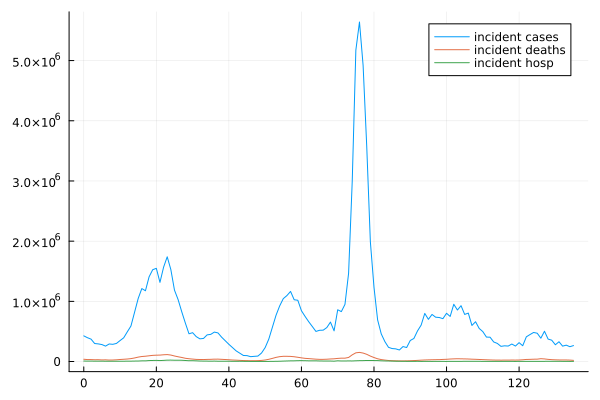

In [5]:
function plot_covidhub(df)
    plt = plot()
    plot!(plt, df.week_number, df.cases_sum; label = "incident cases")
    plot!(plt, df.week_number, df.deaths_sum; label = "incident deaths")
    plot!(plt, df.week_number, df.hosp_sum; label = "incident hosp")
    plt
end
plot_covidhub(df)

2. Split the dataset into a list of sub-datasets covering time periods of interest
    * select_timeperiods(df::DataFrame)::Vector{DataFrame}}


In [6]:
function select_timeperiods(df::DataFrame, split_length::Int)
    if split_length < 1
        error("Split length must be a positive integer.")
    end
    return [df[i:i+split_length-1, :] for i in 1:split_length:(nrow(df)-split_length+1)]
end

select_timeperiods (generic function with 1 method)

In [7]:
data = select_timeperiods(df, 6)

22-element Vector{DataFrame}:
 6×4 DataFrame
 Row │ week_number  cases_sum  deaths_sum  hosp_sum 
     │ Int64        Int64      Int64       Int64    
─────┼──────────────────────────────────────────────
   1 │           0     426504       38039      7823
   2 │           1     396061       32638      7369
   3 │           2     372155       32164      7097
   4 │           3     299096       29605      6046
   5 │           4     292841       30061      6228
   6 │           5     281799       26604      5821
 6×4 DataFrame
 Row │ week_number  cases_sum  deaths_sum  hosp_sum 
     │ Int64        Int64      Int64       Int64    
─────┼──────────────────────────────────────────────
   1 │           6     256026       28030      5071
   2 │           7     291617       24191      5275
   3 │           8     286018       25358      5347
   4 │           9     300436       28491      4953
   5 │          10     348113       33744      5113
   6 │          11     394038       37562      514

In [64]:
petri = read_json_acset(PropertyLabelledReactionNet{Number,Number,Dict}, joinpath(@__DIR__, "../examples/BIOMD0000000955_miranet.json"))
ssnames = string.(snames(petri))
psnames = string.(tnames(petri))
ps =  .=> petri[:rate]
u0 =  .=> (petri[:concentration] .* 300_000_000)

sys_ps = Dict(ps) 
initials = Dict(u0)
defaults = merge(sys_ps, initials)
tspan = (0.0, 100.0)
sidarthe = sys = ODESystem(petri)
sys_syms(sys)  = [states(sys); parameters(sys)]
syms = sys_syms(sys)

(0.0, 100.0)

11-element Vector{Pair{String, Float64}}:
      "Susceptible" => 2.9999889e8
         "Infected" => 999.999999
        "Diagnosed" => 99.9999999
           "Ailing" => 4.99999998
       "Recognized" => 9.99999999
           "Healed" => 0.0
       "Threatened" => 0.0
          "Extinct" => 0.0
            "Cases" => 0.0
 "Hospitalizations" => 0.0
           "Deaths" => 0.0

3. Generate model-model and model-dataset alignment/map during structural comparisons
    * e.g. {("model0.S", "model1.s", ...):  "dataset.feature0", ...} 
    * V{Tuple{V{State/Obs}, Symbol}}. Hosp, cases, 


In [60]:
@unpack Susceptible, Infected, Diagnosed, Ailing, Recognized, Threatened, Healed, Extinct = sidarthe
@variables t Hospitalizations(t) Cases(t) Deaths(t)
S, I, D, A, R, T, H, E = Susceptible, Infected, Diagnosed, Ailing, Recognized, Threatened, Healed, Extinct

nt = (; petri, params=sys_ps, initials, tspan)

(petri = PropertyLabelledReactionNet{Number, Number, Dict}:
  T = 1:16
  S = 1:11
  I = 1:20
  O = 1:20
  it : I → T = [1, 1, 2, 2, 3, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
  is : I → S = [3, 1, 4, 1, 5, 1, 2, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 7, 7]
  ot : O → T = [1, 1, 2, 2, 3, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
  os : O → S = [3, 2, 4, 2, 5, 2, 2, 2, 3, 4, 6, 5, 6, 5, 6, 7, 7, 6, 8, 6]
  rate : T → Rate = Number[0.011, 0.456, 0.011, 0.57, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
  concentration : S → Concentration = Number[0.9999963, 3.33333333e-6, 3.33333333e-7, 1.66666666e-8, 3.33333333e-8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  tname : T → Name = [:t1, :t2, :t3, :t4, :t5, :t6, :t7, :t8, :t9, :t10, :t11, :t12, :t13, :t14, :t15, :t16]
  sname : S → Name = [:Susceptible, :Infected, :Diagnosed, :Ailing, :Recognized, :Healed, :Threatened, :Extinct, :Cases, :Hospitalizations, :Deaths]
  sprop : S → Prop = Dict[Dict{String

In [68]:
defaults

Dict{String, Float64} with 27 entries:
  "t3"               => 0.011
  "t7"               => 0.034
  "Infected"         => 1000.0
  "Extinct"          => 0.0
  "t14"              => 0.017
  "Diagnosed"        => 100.0
  "Hospitalizations" => 0.0
  "t16"              => 0.017
  "t10"              => 0.371
  "t5"               => 0.171
  "Ailing"           => 5.0
  "Deaths"           => 0.0
  "t4"               => 0.57
  "t13"              => 0.027
  "t12"              => 0.017
  "t15"              => 0.01
  "Healed"           => 0.0
  "t2"               => 0.456
  "t11"              => 0.017
  ⋮                  => ⋮

In [66]:
eqs = [ModelingToolkit.equations(sys)[1:end-3]; Hospitalizations ~ Recognized + Threatened; Cases ~ Diagnosed + Recognized + Threatened; Deaths ~ Extinct]
sidarthe = sys = ODESystem(eqs, defaults, t, defaults; tspan, name=:sidarthe)
prob=ODEProblem(sys)

ArgumentError: ArgumentError: broadcasting over dictionaries and `NamedTuple`s is reserved

4. Build an ensemble model using a list of the above models and alignment/map.
    * build_ensemble_model(Tuple{Vector<ODESystem>, typeof(3)})::EnsembleProblem | Vector{ODEProblem}


In [47]:
df = Scheduler.SciMLInterface.forecast(; nt...)

Row,timestamp,Susceptible(t),Infected(t),Diagnosed(t),Ailing(t),Recognized(t),Healed(t),Threatened(t),Extinct(t),Cases(t),Hospitalizations(t),Deaths(t)
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,2.99999e8,1000.0,100.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.47308e-115,2.15675e8,4.02236e7,2.59758e7,8.06873e6,9.73123e6,3.2453e5,1080.77,0.0,0.0,0.0
3,2.0,-6.1448e-122,1.55045e8,6.32345e7,3.60073e7,2.5802e7,1.86114e7,1.29158e6,8651.73,0.0,0.0,0.0
4,3.0,-8.45261e-123,1.1144e8,7.47462e7,3.74593e7,4.67231e7,2.67558e7,2.84616e6,28917.6,0.0,0.0,0.0
5,4.0,-5.61801e-124,8.00844e7,7.8725e7,3.46533e7,6.73062e7,3.42628e7,4.90105e6,67327.7,0.0,0.0,0.0
6,5.0,-4.61023e-125,5.7549e7,7.79082e7,3.00584e7,8.57811e7,4.12157e7,7.35915e6,128377.0,0.0,0.0,0.0
7,6.0,2.05567e-125,4.133e7,7.42011e7,2.5044e7,1.01399e8,4.76872e7,1.01233e7,2.15647e5,0.0,0.0,0.0
8,7.0,-6.15456e-126,2.96766e7,6.88577e7,2.02882e7,1.14002e8,5.37374e7,1.31067e7,331709.0,0.0,0.0,0.0
9,8.0,2.09147e-126,2.13062e7,6.27307e7,1.61022e7,1.23732e8,5.94185e7,1.62324e7,4.78357e5,0.0,0.0,0.0


5. Build and run an ensemble calibration simulator 
    * Select the list of split ground-truth sub-datasets as training-test datasets
    * Select the ensemble model as the input model
    * Select the alignment/map
    * Specify the ensemble calibration mode (no-training-equal-weights, separate-model-weight training, joint model-weight training)
    * Specify the train-validate-test ratio, cross-validation mode, loss function, early-stop condition, etc.
    * ensemble_calibrate_separate(typeof(4), typeof(2)[1][1]; optimization_options)::V<(calibrationmap,loss,weights)>
    * Total 1-4. train 1-2, test 3-4. Trainloss = l2(1-2), testloss = l2(3-4)  


6. Assess consistency of the ensemble by tracking the smoothness/continuity of the ensemble weights across the time periods of interest. (plots from page 1, and bar plot)

7. Build and run a forecast simulator
    * Select the alignment/map from 
    * Select the ensemble model from 
    * Select the calibrated parameter output from 
    * Select the time points of the forecast horizon 
    * forecast(calibrated 4, df), forecast(4, df, calibrationmap)
    * ensemble_forecast(4, df, map, weights)
